## measuring memory latency 

The purpose of this exercise is to test how fast different compture's can run the computationally intensive tasks. 

The results in this notebook are specific to my notebook, which is a recent model powermac pro. More details can be seen in the section "Collecting System Description".

We recommend that you run the notebook on your notebook to measure the latencies on your computer.

Please Note: There are cells marked to be run by specific OS users. So, for those cells, run only the ones for the OS you are using. For example, if you are a windows OS user, then run only "Collecting System Description: For Windows  users ONLY" and not other cells.

### Import modules

In [1]:
# Enable automatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

%pylab inline
from numpy import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time
from matplotlib.backends.backend_pdf import PdfPages

from os.path import isfile,isdir
from os import mkdir
import os

In [3]:
import sys
sys.path.append('./lib')
from measureRandomAccess import measureRandomAccess
from PlotTime import PlotTime
from create_file import create_file,tee

### defining memory latency
Latency is the time difference between:

* The time at which the CPU is issuing a read or write command and,

* The time the command is complete.

* This time is  very short if the element is already in the L1 Cache, 
* and is very long if the element is in external memory (disk or SSD).

### setting parameters
* We test access to elements arrays whose sizes are:
   * 1MB, 10MB, 100MB, 1000MB (=1GB)
* Arrays are stored **in memory** or **on disk**

* We perform 1 million read/write ops  to random locations in the array.
* We analyze the **distribution** of the latencies as a function of the size of the array.

In [4]:
m_list=[10,1000,10000,100000,1000000,10000000,100000000,1000000000]
m_legend=['10B','1KB','10KB','100KB','1MB','10MB','100MB','1GB']
L=len(m_list)
k=10000
print('m_list=',m_list)

m_list= [10, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]


### Set working directory
This script generates large files. We put these files in a separate directory so it is easier to delete them later.

In [5]:
log_root='./logs'
if not isdir(log_root): mkdir(log_root)
TimeStamp=str(int(time.time()))
log_dir=log_root+'/'+TimeStamp
mkdir(log_dir)
%cd $log_dir
stat=open('stats.txt','w')

def tee(line):
    print(line)
    stat.write(line+'\n')

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section1-Basics/0.MemoryLatency/logs/1520551658


In [6]:
_mean=zeros([2,L])   #0: using disk, 1: using memory
_std=zeros([2,L])
_block_no=zeros([L])
_block_size=zeros([L])
T=zeros([2,L,k])

In [7]:
Random_pokes=[]
Min_Block_size=1000000
for m_i in range(len(m_list)):
    
    m=m_list[m_i]
    blocks=int(m/Min_Block_size)
    if blocks==0:
        _block_size[m_i]=1
        _block_no[m_i]=m
    else:
        _block_size[m_i]=Min_Block_size
        _block_no[m_i]=blocks
    (t_mem,t_disk) = create_file(int(_block_size[m_i]),int(_block_no[m_i]),filename='BlockData'+str(m))

    (_mean[0,m_i],_std[0,m_i],T[0,m_i]) = measureRandomAccess(m,filename='BlockData'+str(m),k=k)
    T[0,m_i]=sorted(T[0,m_i])
    tee('\rFile pokes _mean='+str(_mean[0,m_i])+', file _std='+str(_std[0,m_i]))

    (_mean[1,m_i],_std[1,m_i],T[1,m_i]) = measureRandomAccess(m,filename='',k=k)
    T[1,m_i]=sorted(T[1,m_i])
    tee('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
    
    Random_pokes.append({'m_i':m_i,
                        'm':m,
                        'memory__mean': _mean[1,m_i],
                        'memory__std': _std[1,m_i],
                        'memory_largest': T[1,m_i][-1000:],
                        'file__mean': _mean[0,m_i],
                        'file__std': _std[0,m_i],
                        'file_largest': T[0,m_i][-1000:]                
                })
print('='*50)

              
creating 1 byte block: 0.000002 sec, writing 10 blocks 0.004067 sec
File pokes _mean=2.48636722565e-05, file _std=8.54514179189e-06
Memory pokes _mean=6.24442100525e-08, Memory _std=1.26243709703e-06
              
creating 1 byte block: 0.000002 sec, writing 1000 blocks 0.006178 sec
File pokes _mean=2.58234262466e-05, file _std=1.16780793105e-05
Memory pokes _mean=5.86471557617e-08, Memory _std=1.14866956722e-06
              
creating 1 byte block: 0.000002 sec, writing 10000 blocks 0.017411 sec
File pokes _mean=3.02572965622e-05, file _std=2.10261790861e-05
Memory pokes _mean=6.48806095123e-08, Memory _std=1.26765608657e-06
              
creating 1 byte block: 0.000002 sec, writing 100000 blocks 0.938758 sec
File pokes _mean=3.16393852234e-05, file _std=5.4173518384e-05
Memory pokes _mean=6.39684200287e-08, Memory _std=1.36711369192e-06
              
creating 1000000 byte block: 0.000502 sec, writing 1 blocks 0.004442 sec
File pokes _mean=2.12349176407e-05, file _st

Memory Blocks of size 100000000 bytes
 Poke time _mean=1.81258678436e-07,  std=3.96877211054e-06


1

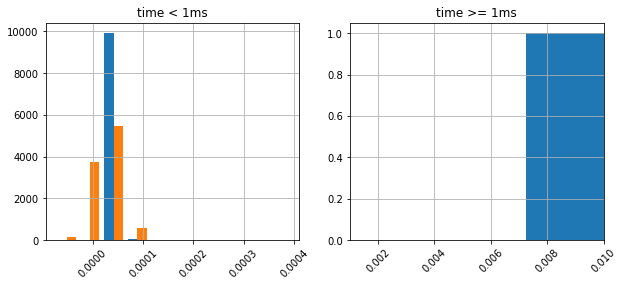

In [10]:
m_i=6
Disk_Mem=0
print('Memory Blocks of size %d bytes'%m_list[m_i])
print('\r Poke time _mean='+str(_mean[1,m_i])+',  std='+str(_std[1,m_i]))
_mean_t=_mean[Disk_Mem,m_i]
_std_t=_std[Disk_Mem,m_i]
_normal=random.normal(loc=_mean_t,scale=_std_t,size=T.shape[2])
tmp=T[Disk_Mem,m_i]
figure(figsize=(10,4))
subplot(121)
thr=1e-3
hist([tmp[tmp<thr],_normal[_normal<thr]],bins=10);
title('time < 1ms')
xticks(rotation=45)
grid()
subplot(122)
hist([tmp[tmp>=thr],_normal[_normal>=thr]],bins=20);
xlim([thr,thr*10])
title('time >= 1ms')
xticks(rotation=45);
grid();1

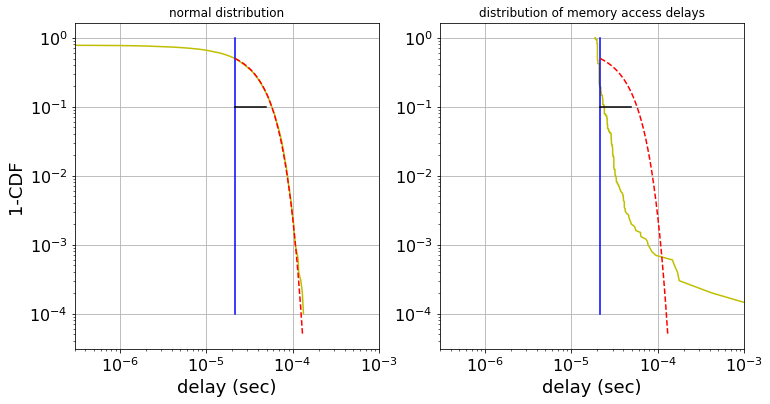

In [23]:
figure(figsize=(12,6))
subplot(121)
grid()
PlotTime(sort(_normal),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'])
title('normal distribution')
xlabel('delay (sec)',fontsize=18)
xlim([3e-7,1e-3])
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)

#print('%d Memory Blocks of size %d bytes'%(m_list[m_i],n))
#print('\rMemory pokes _mean='+str(_mean[1,m_i])+', Memory _std='+str(_std[1,m_i]))
subplot(122)
grid()
PlotTime(sort(tmp),_mean_t,_std_t,Color=['y','b','k','r'],LS=['-','-','-','--'])
title('distribution of memory access delays')
xlabel('delay (sec)',fontsize=18)
xlim([3e-7,1e-3])
#ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)

### Characterize random access to storage

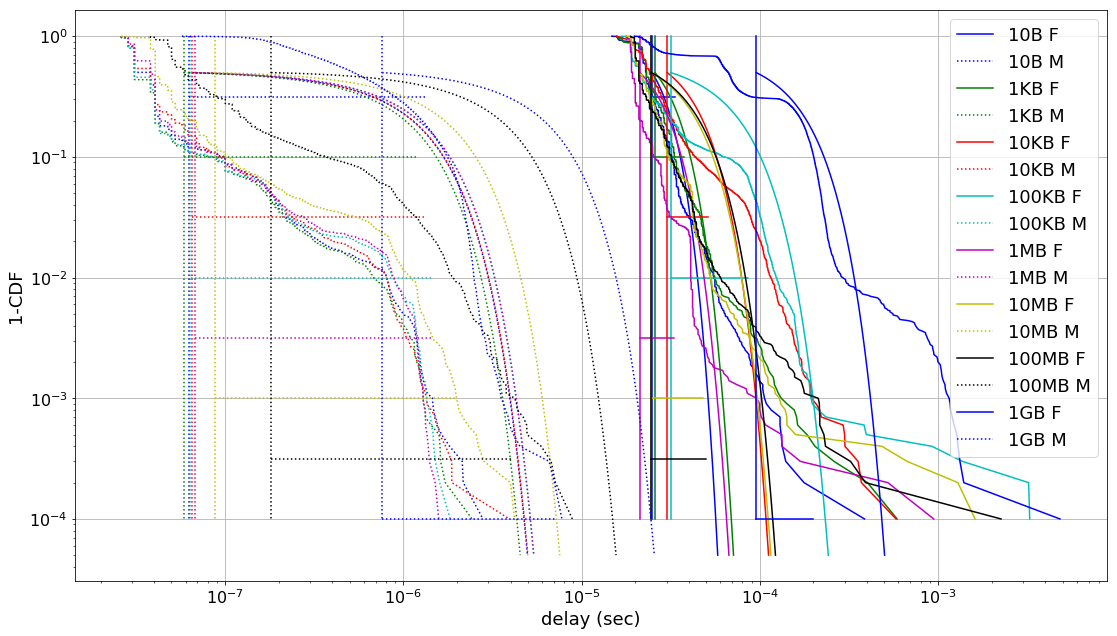

In [11]:
pp = PdfPages('MemoryFigure.pdf')
figure(figsize=(6,4))

Colors='bgrcmyk'  # The colors for the plot
LineStyles=['-',':']
Legends=['F','M']

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5,10.5)

for m_i in range(len(m_list)):
    Color=Colors[m_i % len(Colors)]
    for Type in [0,1]:
        
        PlotTime(sort(T[Type,m_i]),_mean[Type,m_i],_std[Type,m_i],\
             Color=Color,LS=LineStyles[Type],Legend=m_legend[m_i]+' '+Legends[Type],\
             m_i=m_i)

grid()
legend(fontsize=18)
xlabel('delay (sec)',fontsize=18)
ylabel('1-CDF',fontsize=18)
tick_params(axis='both', which='major', labelsize=16)
tick_params(axis='both', which='minor', labelsize=12)
pp.savefig()
pp.close()

### Characterize sequential access

In [20]:
import time
Consec=[]
Line='### Consecutive Memory writes:'
print(Line); stat.write(Line+'\n')
n=1000
r=np.array(list(range(n)))
Header="""
|   size (MB) | Average Latency |
| ---------: | --------------: | """
tee(Header)
for m in [1,100,10000,1000000]:
    t1=time.time()
    A=np.repeat(r,m)
    t2=time.time()
    Consec.append((n,m,float(n*m)/1000000,(t2-t1)/float(n*m)))
    tee("| %6.3f | %4.2g |" % (float(n*m)/1000000,(t2-t1)/float(n*m)))
A=[];r=[]
stat.close()

### Consecutive Memory writes:

|   size (MB) | Average Latency |
| ---------: | --------------: | 
|  0.001 | 3.4e-08 |
|  0.100 | 7.8e-09 |
| 10.000 | 7.3e-09 |
| 1000.000 | 8e-09 |


### Consecutive Memory writes:

<img alt="" src="Figures/Sequential_access_latency.png" style="width:300px" />

* Latency changes little with array size.

* Latency is about $10^{-9} - 10^{-8}$ while latency for random access is about $10^{-6}$

## Collecting System Description
In this section you will find commands that list properties of the hardware you are using.

### Are you using a Virtual Machine?
If you are, Uncomment the following code so that `isVM` is set to `["True"]`

In [ ]:
isVM = ["False"]
#isVM = ["True"]

### For Mac users

The next cell needs to be run only by Mac OS users. If run on other OS platforms, it will throw error. 

In [ ]:
brand_name = ["brand: Macbook"]
os_info = !sysctl kernel.osrelease kernel.osrevision kernel.ostype kernel.osversion
cpu_info = !sysctl machdep.cpu.brand_string machdep.cpu.cache.L2_associativity machdep.cpu.cache.linesize machdep.cpu.cache.size machdep.cpu.core_count
cache_info = !sysctl kern.procname hw.memsize hw.cpufamily hw.activecpu hw.cachelinesize hw.cpufrequency hw.l1dcachesize hw.l1icachesize hw.l2cachesize hw.l3cachesize hw.cputype 

### For Linux OS users

The next cell needs to be run only by Linux OS users. If run on other OS platforms, it will throw error.

In [ ]:
brand_name = ["brand: Linux"]

os_info = !sysctl kernel.ostype kernel.osrelease 
os_version = !lsb_release -r
memory_size = !cat /proc/meminfo | grep 'MemTotal'
os_info += os_version + memory_size

cache_L1i = !lscpu | grep 'L1i'
cache_L1d = !lscpu | grep 'L1d'
cache_L2 = !lscpu | grep 'L2'
cache_L3 = !lscpu | grep 'L3'
cache_info = cache_L1i + cache_L1d + cache_L2 + cache_L3

cpu_type = !lscpu | grep 'CPU family'
cpu_brand = !cat /proc/cpuinfo | grep -m 1 'model name'
cpu_frequency = !lscpu | grep 'CPU MHz'
cpu_core_count = !lscpu | grep 'CPU(s)'
cpu_info = cpu_type + cpu_brand + cpu_frequency + cpu_core_count



###  For Windows users
The next cell needs to be run only by Windows OS users. If run on other OS platforms, it will throw error.

In [ ]:
brand_name = ["brand: Windows"]

os_release  = !ver
os_type     = !WMIC CPU get  SystemCreationClassName
memory      = !WMIC ComputerSystem get TotalPhysicalMemory
os_info     = os_release + os_type

cpu_core_count  = !WMIC CPU get NumberOfCores
cpu_speed       = !WMIC CPU get CurrentClockSpeed
cpu_model_name  = !WMIC CPU get name
cpu_info        = cpu_core_count + cpu_speed + cpu_model_name

l2cachesize = !WMIC CPU get L2CacheSize
l3cachesize = !WMIC CPU get L3CacheSize
cache_info  = l2cachesize + l3cachesize


In [ ]:
description= isVM + brand_name + os_info + cache_info + cpu_info
description

### memory and cache sizes for Macbook Pro

<img alt="" src="Figures/MacBookProMemorySizes.png" style="width:500px" />

In [ ]:
# Writing all necesarry information int oa pickle file.
import pickle
with open('memory_report.pkl','wb') as pickle_file:
    pickle.dump({'description':description,
                'Consec':Consec,
                'Random_pokes':Random_pokes},
               pickle_file)

## Observations

* If you write to consecutive locations, you have a per-byte time of around $10^{-8}$ if you jump around you can't do better than $10^{-6}$.

* As you increase the size of the array/file random access speed decreases dramatically, while sequential access speed stays more or less constant.

* The high latency tails can be much bigger than what you'd expect from a normal distribution with the same mean and std.

### Impact on Big Data Analytics

* Clock rate is stuck at around 3GHz, and is likely to be stuck there for the forseeable future.

* **Faster** computers / disks / networks are **expensive** 

* The cost-effective solution is often a cluster of many cheap computers, each with many cores and break up the data so that each computer has a small fraction of the data.

* Data-Centers and the "Cloud"

* I invite you to use this notebook on your computer to get a better understanding of its memory access latency.

## Clean-Up
Make sure to delete the logs directory! The commands that you ran above made the log directory very big, you WILL NOT be submitting the log directory.

In [26]:
%cd /Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section1-Basics/0.MemoryLatency/

!rm -rf logs

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section1-Basics/0.MemoryLatency
